<a href="https://colab.research.google.com/github/ziatdinovmax/NeuroBayes/blob/main/examples/PartialBayesianTransformer_esol.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Partially Bayesian Transformer - Molecular Property Prediction from SMILES

*Prepared by Maxim Ziatdinov (February 2025)*

This notebook demonstrates the application of Partially Bayesian Transformers to predict molecular solubility from SMILES representations using the NeuroBayes framework. It starts with a deterministic transformer model for the ESOL dataset, then converts it into partially Bayesian models by making different components probabilistic - specifically the token embedding layer, final dense layer, and attention layer.

Install NeuroBayes:

In [1]:
!pip install git+https://github.com/ziatdinovmax/NeuroBayes

  Cloning https://github.com/ziatdinovmax/NeuroBayes to /tmp/pip-req-build-350_dh23
  Running command git clone --filter=blob:none --quiet https://github.com/ziatdinovmax/NeuroBayes /tmp/pip-req-build-350_dh23
  Resolved https://github.com/ziatdinovmax/NeuroBayes to commit 668d10d3130362e74dba9221bcdc887b76b1951d
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 30.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.1/88.1 MB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 360.8/360.8 kB 21.2 MB/s eta 0:00:00
  Created wheel for NeuroBayes: filename=NeuroBayes-0.0.12-py3-none-any.whl size=70460 sha256=cf31aa2fe9178eba0000e6d45ad05fa218692d940c8e21e90a5a1aae49a1381c
  Stored in directory: /tmp/pip-ephem-wheel-cache-xdg9khda/wheels/52/f4/85/0e45c139ca1e184850945237cf19f7edb55c1ff7afbd82a351
Successfully built NeuroBayes
  Attempting uninstall: jaxlib
    Found existing installation: jaxlib 0.4.33
    Uninstalli

Download dataset:

In [2]:
!wget https://raw.githubusercontent.com/deepchem/deepchem/master/datasets/delaney-processed.csv

--2025-02-24 18:29:02--  https://raw.githubusercontent.com/deepchem/deepchem/master/datasets/delaney-processed.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 96699 (94K) [text/plain]
Saving to: ‘delaney-processed.csv’

delaney-processed.c 100%[===================>]  94.43K  --.-KB/s    in 0.02s   

2025-02-24 18:29:02 (4.06 MB/s) - ‘delaney-processed.csv’ saved [96699/96699]



Check that GPU is available:

In [3]:
!nvidia-smi

Mon Feb 24 18:29:02 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   29C    P0             45W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

Import neccessary libraries:

In [1]:
import neurobayes as nb

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

Preprocess data:

In [2]:
class SMILESTokenizer:
    def __init__(self):
        self.chars = set(' ()[]{}=-#@+/\\.%$NH?OSCFIBrclnop0123456789')
        self.char_to_idx = {char: idx for idx, char in enumerate(self.chars)}
        self.idx_to_char = {idx: char for char, idx in self.char_to_idx.items()}
        self.vocab_size = len(self.chars)

    def encode(self, smiles):
        return [self.char_to_idx.get(c, self.char_to_idx['?']) for c in smiles]

    def decode(self, tokens):
        return ''.join([self.idx_to_char[t] for t in tokens])


def load_esol_data(file_path):
    """Load ESOL dataset from CSV"""
    df = pd.read_csv(file_path)

    smiles_col = [col for col in df.columns if 'SMILES' in col.upper()][0]
    solubility_col = [col for col in df.columns if 'SOLUBILITY' in col.upper()][0]

    return df[smiles_col].values, df[solubility_col].values

def prepare_dataset(smiles_list, solubility_values, max_length=128):
    """Prepare entire dataset"""
    tokenizer = SMILESTokenizer()
    encoded = [tokenizer.encode(s) for s in smiles_list]
    padded = [seq + [0] * (max_length - len(seq)) if len(seq) < max_length
             else seq[:max_length] for seq in encoded]
    return {
        'input_ids': np.array(padded, dtype=np.int32),
        'solubility': np.array(solubility_values, dtype=np.float32)
    }

smiles_list, solubility_values = load_esol_data('delaney-processed.csv')

X_train, X_test, y_train, y_test = train_test_split(
    smiles_list, solubility_values, test_size=0.5, random_state=1
)

train_data = prepare_dataset(X_train.tolist(), y_train.tolist())
test_data = prepare_dataset(X_test.tolist(), y_test.tolist())

Initialize and train a deterministic transformer model:

In [3]:
tokenizer = SMILESTokenizer()
model = nb.flax_nets.FlaxTransformer(
    vocab_size=tokenizer.vocab_size,
    d_model=16,
    nhead=4,
    num_layers=2,
    dim_feedforward=64)

nn_model = nb.DeterministicNN(
    architecture=model,
    input_shape=128,
    learning_rate=1e-3,
    map=False,
    swa_config={'schedule': 'constant', 'start_pct': 0.90},
    collect_gradients=False
)


nn_model.train(
    train_data['input_ids'],
    train_data['solubility'],
    epochs=50,
    batch_size=32
)

Training Progress: 100%|██████████| 50/50 [00:17<00:00,  2.80it/s, Epoch 50/50, LR: 0.001000, Loss: 0.2789 ]


Make a prediction with the trained deterministic transformer:

In [4]:
# Get predictions on test set
predictions = nn_model.predict(test_data['input_ids']).squeeze()

# Compute RMSE and R^2
test_rmse = np.sqrt(np.mean((test_data['solubility'] - predictions) ** 2))
test_r2 = r2_score(test_data['solubility'], predictions)

print("\nModel Performance:")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Test R²: {test_r2:.4f}")

# Show example predictions
print("\nExample Predictions:")
for i in range(min(5, len(X_test))):
    pred = float(nn_model.predict(test_data['input_ids'][i:i+1])[0, 0])  # Access the scalar value
    print(f"SMILES: {X_test[i]}")
    print(f"True Solubility: {y_test[i]:.2f}")
    print(f"Predicted Solubility: {pred:.2f}\n")


Model Performance:
Test RMSE: 0.5376
Test R²: 0.8925

Example Predictions:
SMILES: CCCCCCCCCC(=O)OC
True Solubility: -3.32
Predicted Solubility: -2.62

SMILES: Cc1cc(ccc1NS(=O)(=O)C(F)(F)F)S(=O)(=O)c2ccccc2
True Solubility: -4.95
Predicted Solubility: -4.49

SMILES: Nc1nc[nH]n1
True Solubility: -0.67
Predicted Solubility: -0.31

SMILES: Clc1ccc(c(Cl)c1)c2cc(Cl)c(Cl)c(Cl)c2Cl 
True Solubility: -7.34
Predicted Solubility: -7.07

SMILES: CCOC(=O)c1ccccc1
True Solubility: -2.77
Predicted Solubility: -2.88



Next, we convert our deterministic Transformer model into a partially Bayesian Transformer. We will test three types of layers: token embedding, attention, and final (fully connected) layer. Since making even a single layer probabilistic introduces substantial computational overhead, we will select only a subset of weights from that layer for Bayesian treatment. There are multiple ways to select this subset of probabilistic weights - based on magnitude, variance, and changes in gradient. At this point, it's not entirely clear to me which method should be used in which situation. For this tutorial notebook, we'll stick to 'variance', but feel free to explore other options, including completely random selection.

If you see the sampling seriously struggling (very small step size and acceptance probability close to zero) after more than 20% of warmup steps, I recommend stopping it and changing the probabilistic weights selection strategy.

NeuroBayes has a utility function for printing each layer name and specs, which makes the selection and assignment process easier:

In [5]:
nb.print_layer_configs(nn_model.model)


Model Architecture: FlaxTransformer

layer_name         layer_type  features  num_embeddings
-------------------------------------------------------
TokenEmbed         embedding   16        42            
PosEmbed           embedding   16        1024          
Block0_Attention   attention   16      
Block0_LayerNorm1  layernorm   -       
Block0_MLP_dense1  fc          64      
Block0_MLP_dense2  fc          16      
Block0_LayerNorm2  layernorm   -       
Block1_Attention   attention   16      
Block1_LayerNorm1  layernorm   -       
Block1_MLP_dense1  fc          64      
Block1_MLP_dense2  fc          16      
Block1_LayerNorm2  layernorm   -       
FinalDense1        fc          64      
FinalDense2        fc          1       

Total layers: 14



Select probabilistic layer(s), a corresponding subset of probabilistic weights, and train a partially Bayesian Transformer:

In [6]:
# Specify probabilistic layers
probabilistic_layers = ['TokenEmbed']

# Select a subset of weights for the selected probabilistic layers
prob_indices = nb.select_bayesian_components(
    nn_model,
    layer_names=probabilistic_layers,
    method='variance',
    num_pairs_per_layer=100
)

# Initialize a partially Bayesian Transformer
pbnn_model = nb.PartialBayesianTransformer(
    nn_model.model,
    deterministic_weights=nn_model.get_params(),
    probabilistic_layer_names=probabilistic_layers,
    probabilistic_neurons=prob_indices
)

# Train
pbnn_model.fit(
    train_data["input_ids"],
    train_data['solubility'],
    num_warmup=1000,
    num_samples=1000,
)

sample: 100%|██████████| 2000/2000 [10:14<00:00,  3.25it/s, 63 steps of size 8.25e-02. acc. prob=0.91]


Compute prediction accuracy and uncertaintyu metrics:

In [7]:
# Get predictions on test set
predictions, variance = pbnn_model.predict(test_data['input_ids'])
predictions = predictions.squeeze()
variance = variance.squeeze()

# Compute RMSE and R^2
test_rmse_emb = np.sqrt(np.mean((test_data['solubility'] - predictions) ** 2))
test_r2_emb = r2_score(test_data['solubility'], predictions)

print("Model Performance:")
print(f"Test RMSE: {test_rmse_emb:.4f}")
print(f"Test R²: {test_r2_emb:.4f}")

# Compute negative log predictive density and coverage probability
test_nlpd_emb = nb.utils.nlpd(test_data['solubility'], predictions, variance)
test_coverage_emb = nb.utils.coverage(test_data['solubility'], predictions, variance)

print(f"NLPD: {test_nlpd_emb:.4f}")
print(f"Coverage probability: {test_coverage_emb:.4f}")

Model Performance:
Test RMSE: 0.5399
Test R²: 0.8915
NLPD: 0.8274
Coverage probability: 0.9096


Now let's do the same for the final learnable layer in the architecture:

In [8]:
probabilistic_layers = ['FinalDense1']

prob_indices = nb.select_bayesian_components(
    nn_model,
    layer_names=probabilistic_layers,
    method='variance',
    num_pairs_per_layer=100
)

pbnn_model = nb.PartialBayesianTransformer(
    nn_model.model,
    deterministic_weights=nn_model.get_params(),
    probabilistic_layer_names=probabilistic_layers,
    probabilistic_neurons=prob_indices
)

pbnn_model.fit(
    train_data["input_ids"],
    train_data['solubility'],
    num_warmup=1000,
    num_samples=1000,
)

sample: 100%|██████████| 2000/2000 [09:50<00:00,  3.39it/s, 127 steps of size 2.92e-02. acc. prob=0.89]


In [9]:
# Get predictions on test set
predictions, variance = pbnn_model.predict(test_data['input_ids'])
predictions = predictions.squeeze()
variance = variance.squeeze()

# Compute RMSE and R^2
test_rmse_fin = np.sqrt(np.mean((test_data['solubility'] - predictions) ** 2))
test_r2_fin = r2_score(test_data['solubility'], predictions)
print("\nModel Performance:")
print(f"Test RMSE: {test_rmse_fin:.4f}")
print(f"Test R²: {test_r2_fin:.4f}")


# Compute negative log predictive density and coverage probability
test_nlpd_fin = nb.utils.nlpd(test_data['solubility'], predictions, variance)
test_coverage_fin = nb.utils.coverage(test_data['solubility'], predictions, variance)
print(f"NLPD: {test_nlpd_fin:.4f}")
print(f"Coverage probability: {test_coverage_fin:.4f}")


Model Performance:
Test RMSE: 0.5389
Test R²: 0.8920
NLPD: 0.8323
Coverage probability: 0.9149


Now let's make one of the attention layers partially probabilisitc. We will also do a 'data thinning', i.e. select only a subset of traning data points, to speed up the computations:

In [10]:
probabilistic_layers = ['Block0_Attention']

prob_indices = nb.select_bayesian_components(
    nn_model,
    probabilistic_layers,
    method='variance',
    num_pairs_per_layer=32)

pbnn_model = nb.PartialBayesianTransformer(
    nn_model.model,
    deterministic_weights=nn_model.get_params(),
    probabilistic_layer_names=probabilistic_layers,
    probabilistic_neurons=prob_indices
)

pbnn_model.fit(
    train_data["input_ids"][::10],  # data thinning
    train_data['solubility'][::10],
    num_warmup=1000,
    num_samples=1000,
)

sample: 100%|██████████| 2000/2000 [05:10<00:00,  6.43it/s, 127 steps of size 3.00e-02. acc. prob=0.94]


Get predictive metrics:

In [11]:
# Get predictions on test set
predictions, variance = pbnn_model.predict(test_data['input_ids'])
predictions = predictions.squeeze()
variance = variance.squeeze()

# Compute RMSE and R^2
test_rmse_att = np.sqrt(np.mean((test_data['solubility'] - predictions) ** 2))
test_r2_att = r2_score(test_data['solubility'], predictions)
print("\nModel Performance:")
print(f"Test RMSE: {test_rmse_att:.4f}")
print(f"Test R²: {test_r2_att:.4f}")


# Compute negative log predictive density and coverage probability
test_nlpd_att = nb.utils.nlpd(test_data['solubility'], predictions, variance)
test_coverage_att = nb.utils.coverage(test_data['solubility'], predictions, variance)
print(f"NLPD: {test_nlpd_att:.4f}")
print(f"Coverage probability: {test_coverage_att:.4f}")


Model Performance:
Test RMSE: 0.5456
Test R²: 0.8892
NLPD: 0.8067
Coverage probability: 0.9291


Finally, let's comppare predictive metrics for the three cases, as well as against Gaussian process baseline (computed in this separate [notebook](https://github.com/ziatdinovmax/NeuroBayes/blob/main/examples/GPyTorch_esol.ipynb)):

<Figure size 2000x600 with 0 Axes>

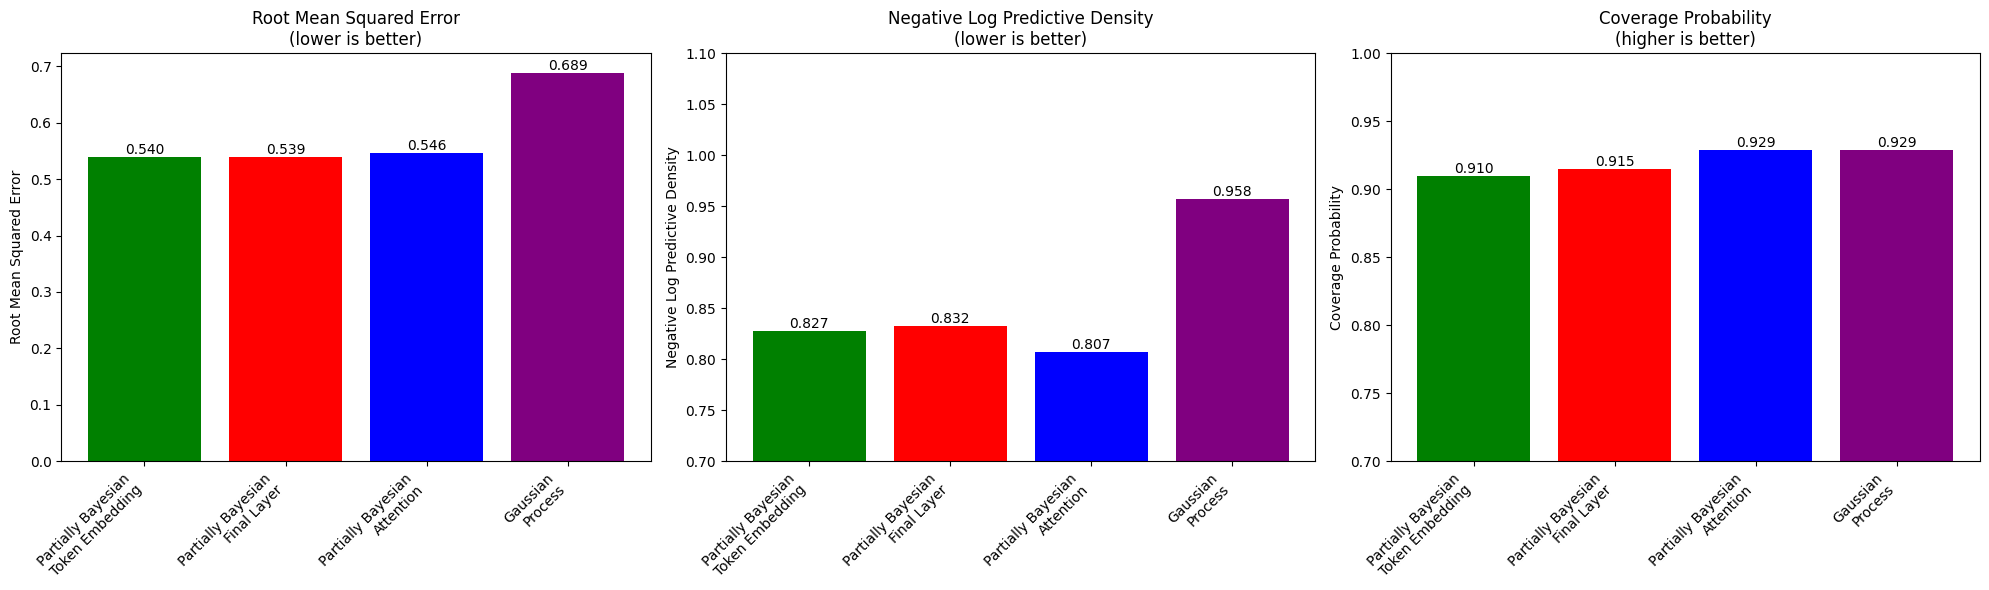

In [12]:
# GP results
test_rmse_gp = 0.6887
test_nlpd_gp = 0.9575
test_coverage_gp = 0.9291

# Labels for the bars
labels = ["Partially Bayesian\nToken Embedding",
          "Partially Bayesian\nFinal Layer",
          "Partially Bayesian\nAttention",
          "Gaussian\nProcess"]

# RMSE, NLPD, and Coverage values
rmse_values = [test_rmse_emb, test_rmse_fin, test_rmse_att, test_rmse_gp]
nlpd_values = [test_nlpd_emb, test_nlpd_fin, test_nlpd_att, test_nlpd_gp]
coverage_values = [test_coverage_emb, test_coverage_fin, test_coverage_att, test_coverage_gp]

# Colors for each model
colors = ['green', 'red', 'blue', 'purple']

# Create figure and axes with more width for the labels
plt.figure(figsize=(20, 6))
_, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(20, 6))

# Function to create bars with error bars
def create_bar_plot(ax, values, title, ylabel, colors, labels):
    bars = ax.bar(np.arange(len(values)), values, color=colors)
    ax.set_xticks(np.arange(len(values)))
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom')
    return bars

# Create the three plots
create_bar_plot(ax0, rmse_values,
                "Root Mean Squared Error\n(lower is better)",
                "Root Mean Squared Error",
                colors, labels)

create_bar_plot(ax1, nlpd_values,
                "Negative Log Predictive Density\n(lower is better)",
                "Negative Log Predictive Density",
                colors, labels)

create_bar_plot(ax2, coverage_values,
                "Coverage Probability\n(higher is better)",
                "Coverage Probability",
                colors, labels)

# Set y-axis limits for NLPD and Coverage as in original
ax1.set_ylim(0.7, 1.1)
ax2.set_ylim(0.7, 1.0)

# Adjust layout to prevent label overlap
plt.tight_layout()
plt.show()